In [ ]:
# Plot data from aerogel XPCS hdf5 file

In [1]:
import time
import h5py
import numpy as np
import pandas as pd
# from tqdm import tqdm
import matplotlib.pyplot as plt

# XPCS raw data and sample file for airmettle work
input_data = "../data/input/comm201901_qmap_aerogel_Lq0.h5"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def print_hdf5_structure(name, obj):
    """Recursively print the structure of the HDF5 file with additional details."""
    indent = "  " * name.count("/")
    if isinstance(obj, h5py.Group):
        print(f"{indent}{name} (Group)")
    elif isinstance(obj, h5py.Dataset):
        print(f"{indent}{name} (Dataset) - shape: {obj.shape}, dtype: {obj.dtype}")
        # Check if it"s a 3D dataset and print value ranges for each dimension
        if len(obj.shape) == 3:
            data = obj[:]
            for i in range(3):
                flattened_data = np.moveaxis(data, i, 0).reshape(data.shape[i], -1)
                min_val = flattened_data.min(axis=1)
                max_val = flattened_data.max(axis=1)
                print(f"{indent}  Dimension {i}: Range {min_val.min()} to {max_val.max()}")
        else:
            if obj.shape:
                data = obj[:]
                print(f"{indent}  Value range: {data.min()} to {data.max()}")
    else:
        print(f"{indent}{name} (Unknown)")


with h5py.File(input_data, "r") as file:
    file.visititems(print_hdf5_structure)


data (Group)
  data/Maps (Group)
    data/Maps/map1name (Dataset) - shape: (), dtype: |S1
    data/Maps/map2name (Dataset) - shape: (), dtype: |S3
    data/Maps/phi (Dataset) - shape: (516, 1556), dtype: float64
      Value range: -269.93267822265625 to 89.84307861328125
    data/Maps/q (Dataset) - shape: (516, 1556), dtype: float64
      Value range: 2.962672442663461e-05 to 0.04281599819660187
    data/Maps/x (Dataset) - shape: (516, 1556), dtype: float64
      Value range: 1.0 to 1556.0
    data/Maps/y (Dataset) - shape: (516, 1556), dtype: float64
      Value range: 1.0 to 516.0
  data/Version (Dataset) - shape: (1,), dtype: float64
    Value range: 4.0 to 4.0
  data/ccdx (Dataset) - shape: (1, 1), dtype: float64
    Value range: 215.3000030517578 to 215.3000030517578
  data/ccdx0 (Dataset) - shape: (1, 1), dtype: float64
    Value range: 209.5 to 209.5
  data/ccdz (Dataset) - shape: (1, 1), dtype: float64
    Value range: 37.099998474121094 to 37.099998474121094
  data/ccdz0 (Data

Dynamic Map shape: (516, 1556)
Dynamic Map dtype: uint32


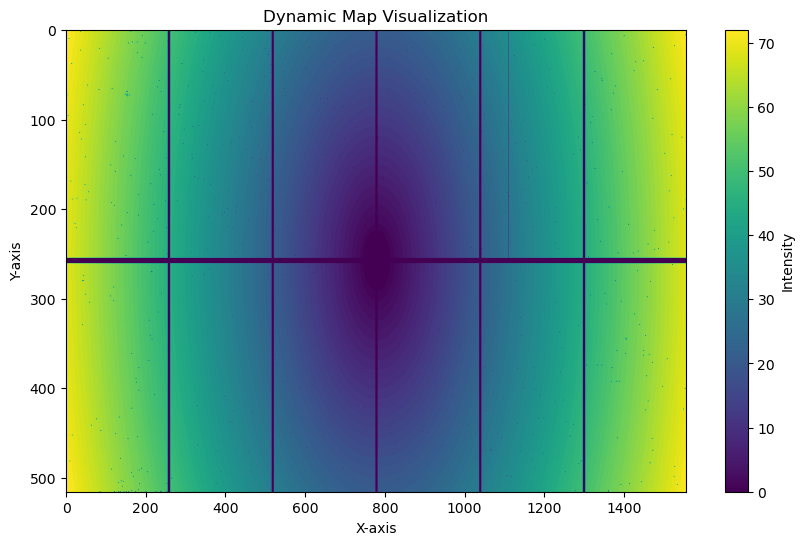

In [5]:
def visualize_dynamic_map(h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5_file:
        dynamic_map = h5_file['data/dynamicMap'][:]
        print("Dynamic Map shape:", dynamic_map.shape)
        print("Dynamic Map dtype:", dynamic_map.dtype)
        
        # Visualize the dynamicMap dataset
        plt.figure(figsize=(10, 6))
        plt.imshow(dynamic_map, cmap='viridis', aspect='auto')
        plt.colorbar(label='Intensity')
        plt.title('Dynamic Map Visualization')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

visualize_dynamic_map(input_data)

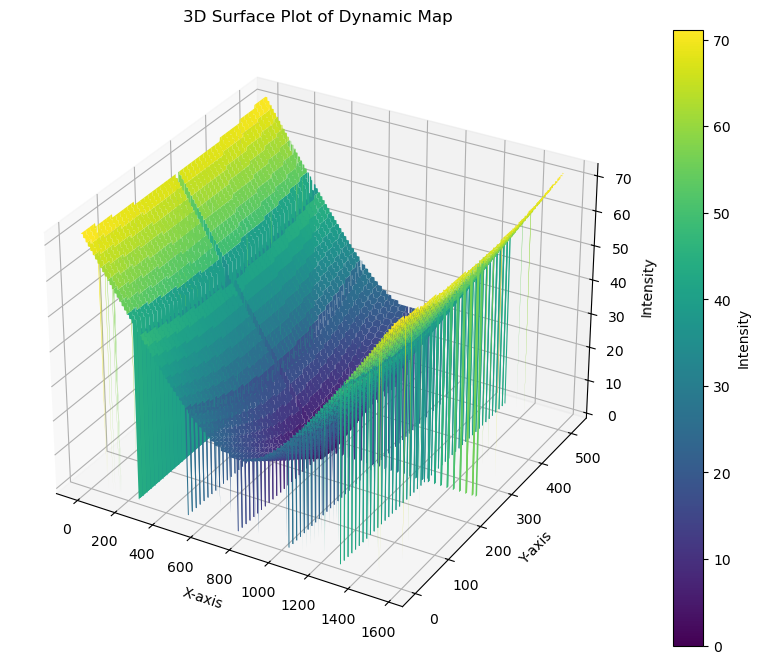

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_surface_plot(dynamic_map):
    x = np.arange(dynamic_map.shape[1])
    y = np.arange(dynamic_map.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = dynamic_map

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax, label='Intensity')
    ax.set_title('3D Surface Plot of Dynamic Map')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Intensity')
    plt.show()

# Example usage
with h5py.File(input_data, 'r') as h5_file:
    dynamic_map = h5_file['data/dynamicMap'][:]
visualize_surface_plot(dynamic_map)

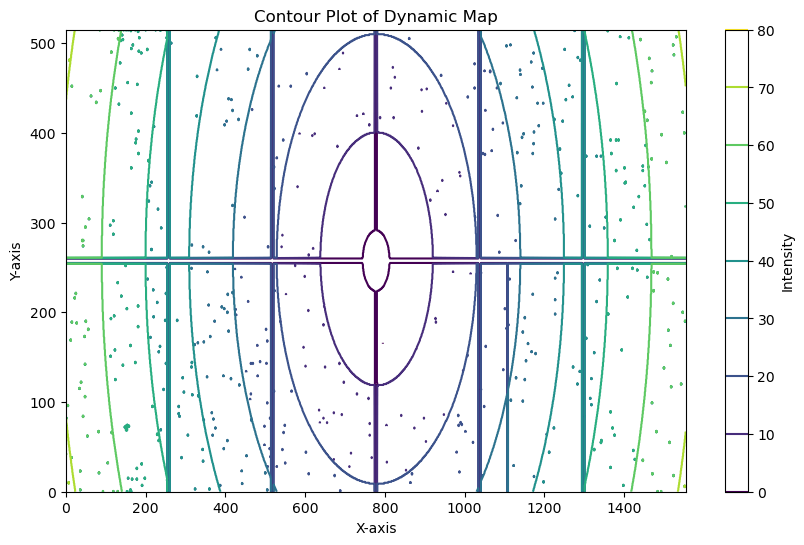

In [11]:
def visualize_contour_plot(dynamic_map):
    plt.figure(figsize=(10, 6))
    plt.contour(dynamic_map, cmap='viridis')
    plt.title('Contour Plot of Dynamic Map')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.colorbar(label='Intensity')
    plt.show()

# Example usage
with h5py.File(input_data, 'r') as h5_file:
    dynamic_map = h5_file['data/dynamicMap'][:]
visualize_contour_plot(dynamic_map)


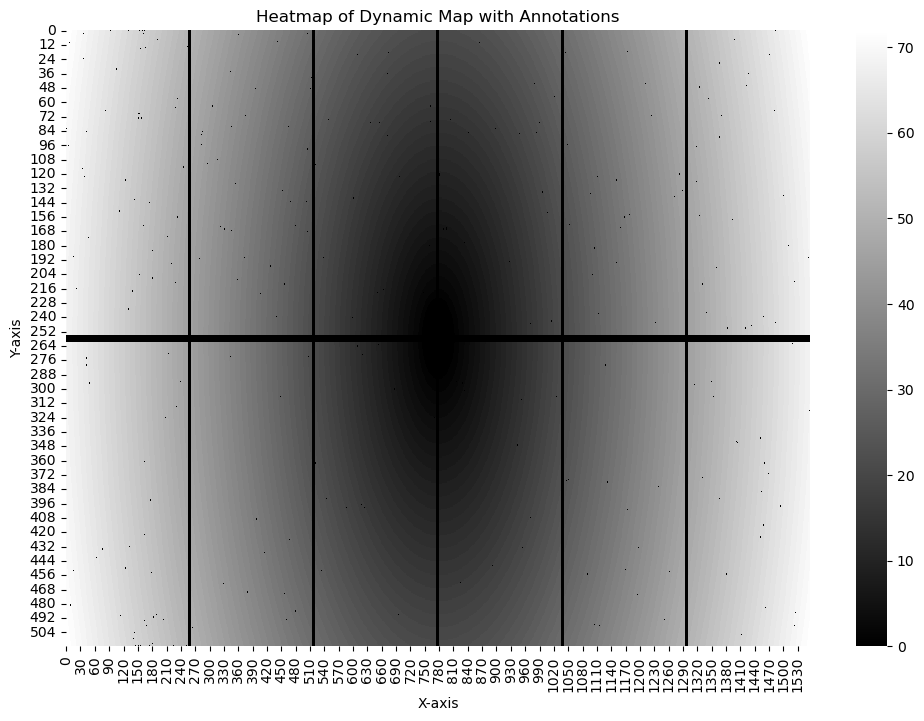

In [14]:
import seaborn as sns

def visualize_heatmap_with_annotations(dynamic_map):
    plt.figure(figsize=(12, 8))
    sns.heatmap(dynamic_map, annot=False, fmt=".1f", cmap='gray')
    plt.title('Heatmap of Dynamic Map with Annotations')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

# Example usage
with h5py.File(input_data, 'r') as h5_file:
    dynamic_map = h5_file['data/dynamicMap'][:]
visualize_heatmap_with_annotations(dynamic_map)

In [ ]:
#STILL NEED TO ADJUST FILTER

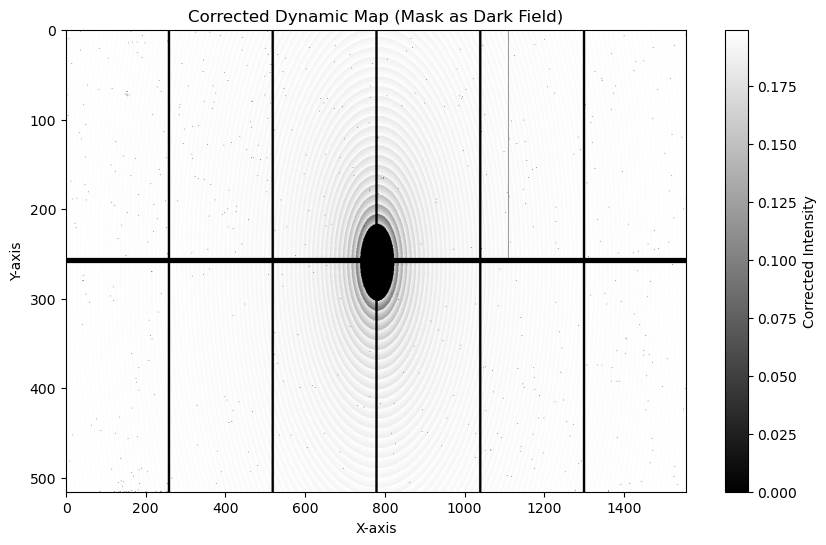

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def correct_image_with_mask_as_dark(raw_image, dark_field, flat_field):
    # Subtract the mask (acting as dark field) from raw image
    corrected_image = raw_image - dark_field
    
    # Ensure no division by zero occurs in the flat field
    flat_field[flat_field == 0] = 1  # Prevent division by zero
    
    # Divide by the flat field (staticMap)
    corrected_image = corrected_image / flat_field
    
    return corrected_image

def visualize_corrected_dynamic_map_with_mask_as_dark(h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5_file:
        # Load the raw data (dynamicMap), mask (as dark field), and flat field data (staticMap)
        raw_image = h5_file['data/dynamicMap'][:]
        dark_field = h5_file['data/mask'][:]
        flat_field = h5_file['data/staticMap'][:]

        # Correct the raw image using mask as dark field and flat field correction
        corrected_image = correct_image_with_mask_as_dark(raw_image, dark_field, flat_field)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(corrected_image, cmap='gray', aspect='auto')
        plt.colorbar(label='Corrected Intensity')
        plt.title('Corrected Dynamic Map (Mask as Dark Field)')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

visualize_corrected_dynamic_map_with_mask_as_dark(input_data)


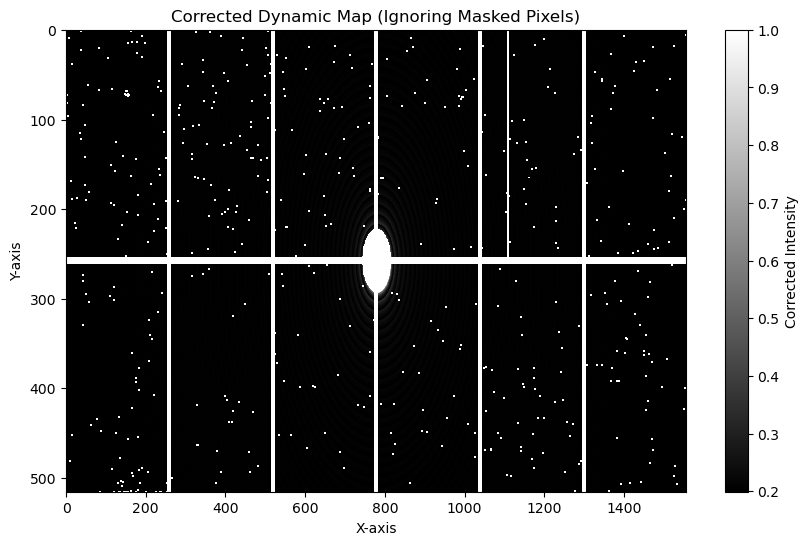

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def correct_image_with_mask(raw_image, mask, flat_field):
    # Apply the mask by setting masked pixels to NaN
    raw_image = np.where(mask == 0, np.nan, raw_image)
    
    flat_field[flat_field == 0] = 1  # Prevent division by zero
    
    # Divide by the flat field (staticMap)
    corrected_image = raw_image / flat_field
    
    return corrected_image

def visualize_corrected_dynamic_map_with_mask(h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5_file:
        # Load the raw data (dynamicMap), mask, and flat field data (staticMap)
        raw_image = h5_file['data/dynamicMap'][:]
        mask = h5_file['data/mask'][:]  # Applying mask to ignore bad pixels
        flat_field = h5_file['data/staticMap'][:]

        # Correct the raw image using mask to ignore bad pixels and flat field correction
        corrected_image = correct_image_with_mask(raw_image, mask, flat_field)
        
        # Visualize the corrected image
        plt.figure(figsize=(10, 6))
        plt.imshow(corrected_image, cmap='gray', aspect='auto')
        plt.colorbar(label='Corrected Intensity')
        plt.title('Corrected Dynamic Map (Ignoring Masked Pixels)')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

# Example usage
visualize_corrected_dynamic_map_with_mask(input_data)
